# Emojitranslate project

## Part one - learning to predict emojis from tweets

The following code adapted from the Osinga deep learning cookbook - using the Twitter API to sample EN language tweets that contain exactly one emoji

In [1]:
import random
import twitter
import emoji
# import itertools
import pandas as pd
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#from sklearn.model_selection import train_test_split
from keras import Sequential, optimizers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
import keras.callbacks
from keras.backend import clear_session
#import json

import os
# import nb_utils
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalMaxPooling1D#, Merge 
from keras.models import Model
from keras.layers.merge import Concatenate, Average

# from gensim.models import Word2Vec

/home/nickdbn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
all_tweets = pd.read_csv('data/emojis_homemade.csv')
all_tweets['emoji'].value_counts()

😂        44794
😭        18356
❤        14875
emoji    10434
😍        10025
🔥         9518
🤣         6295
🤔         4874
🙏         4839
😩         4675
💕         4612
😊         4363
🖤         4313
👀         3908
✨         3789
💜         3744
👏         3639
🙄         3474
💀         3296
🎉         3192
🙌         3004
😘         2876
😏         2865
💯         2744
💙         2665
😔         2616
👍         2576
😎         2425
😉         2408
♥         2386
         ...  
🏨            1
🈲            1
⏸            1
◀            1
🏣            1
📏            1
🛤            1
🚾            1
👝            1
🗜            1
🧙            1
🗄            1
👲            1
🈳            1
🚈            1
👷            1
🚇            1
↕            1
⛎            1
🧚            1
➗            1
📪            1
🕠            1
🧘            1
💇            1
📤            1
📇            1
💹            1
📗            1
🏬            1
Name: emoji, Length: 1069, dtype: int64

In [3]:
all_tweets.shape

(360433, 3)

In [4]:
all_tweets.head

<bound method NDFrame.head of         Unnamed: 0                                               text emoji
0              0.0  RT @mydear_bangtan: [VID] 181023 - Foi adicion...     ©
1              1.0  RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...     💫
2              2.0  RT @TrendsPrabhas: Now you are watching Indian...     😎
3              3.0                                    dats for keeps      💛
4              4.0  RT @xruiztru: WHO ARMS THE SAUDIS?\n\n  🇺🇸US 5...     🏳
5              5.0  RT @xxxfreaknasty2: interracial couple go at i...     🌝
6              6.0               @Eric_Deshaun Holy shit no I think.      😩
7              7.0     RT @fanmutuals: army, follow who retweet this      👑
8              8.0  RT @_Simplykpop: Simply K-Pop harddrive dump\n...     🤩
9              9.0  Happy birthday nellie @thelittlegend, hope you...     ❤
10            10.0  RT @montparnasty: "I have passed through fire"...     💕
11            11.0  RT @Jason_Mckeown: Look how empty Vall

In [5]:
tweets = all_tweets.groupby('emoji').filter(lambda c:len(c) > 1000)
tweets['emoji'].value_counts()

😂        44794
😭        18356
❤        14875
emoji    10434
😍        10025
🔥         9518
🤣         6295
🤔         4874
🙏         4839
😩         4675
💕         4612
😊         4363
🖤         4313
👀         3908
✨         3789
💜         3744
👏         3639
🙄         3474
💀         3296
🎉         3192
🙌         3004
😘         2876
😏         2865
💯         2744
💙         2665
😔         2616
👍         2576
😎         2425
😉         2408
♥         2386
         ...  
😤         1624
☺         1578
©         1577
🤗         1550
🤧         1542
😒         1501
💥         1499
✌         1448
💗         1432
😌         1431
😫         1400
🤝         1381
💔         1378
😈         1359
👉         1349
🙂         1338
☹         1333
🎶         1308
🤩         1268
💚         1235
😆         1226
😋         1174
➡         1173
💞         1116
💓         1112
✅         1088
▶         1087
😡         1056
👑         1054
😪         1005
Name: emoji, Length: 76, dtype: int64

In [6]:
tweets['emoji'].value_counts()[0]/sum(tweets['emoji'].value_counts())

0.168847274522886

In [7]:
max(tweets['text'], key=lambda t:len(t))

'RT @DingDongLive: LMAO  @TexasEDMFamily\n@FreakyDeakyFam\nGrab my hard/hybrid trap mix&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt; https://t.co/34rcxAVbgk https://t.co/ArQeh23L…'

In [8]:
chars = list(sorted(set(chain(*tweets['text']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in tweets['text'])

emojis = list(sorted(set(tweets['emoji'])))
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
emojis[:10]

#train_tweets, test_tweets = train_test_split(tweets, test_size=0.1)

['emoji', '©', '‼', '▶', '☹', '☺', '♥', '✅', '✌', '✨']

Currently we've collected quite a lot of tweet data, so to speed up the prototyping of the model we're going to create a train/dev/test datasets of 10,000 tweets each.

In [9]:
#train_tweets = tweets[0:10000]
#dev_tweets = tweets[10000:20000]
#test_tweets = tweets[20000:30000]


# !! Temp! Try on much bigger dataset
train_tweets = tweets[0:100000] # 100000 tweets
dev_tweets = tweets[100000:110000]
test_tweets = tweets[110000:120000]



In [ ]:
#def data_generator(tweets, batch_size):
#    while True:
#        if batch_size is None:
#            batch = tweets
#            batch_size = batch.shape[0]
#        else:
#            batch = tweets.sample(batch_size)
#        X = np.zeros((batch_size, max_sequence_len, len(chars)))
#        y = np.zeros((batch_size,))
#        for row_idx, (_, row) in enumerate(batch.iterrows()):
#            y[row_idx] = emoji_to_idx[row['emoji']]
#            for ch_idx, ch in enumerate(row['text']):
#                X[row_idx, ch_idx, char_to_idx[ch]] = 1
#        yield X, y
#
#next(data_generator(tweets, 10))

In [ ]:
#def create_char_cnn_model(num_chars, max_sequence_len, num_labels):
#    char_input = Input(shape=(max_sequence_len, num_chars), name='char_cnn_input')
#    
#    conv_1x = Conv1D(128, 6, activation='relu', padding='valid')(char_input)
#    max_pool_1x = MaxPooling1D(4)(conv_1x)
#    conv_2x = Conv1D(256, 6, activation='relu', padding='valid')(max_pool_1x)
#    max_pool_2x = MaxPooling1D(4)(conv_2x)

#    flatten = Flatten()(max_pool_2x)
#    dense = Dense(128, activation='relu')(flatten)
#    preds = Dense(num_labels, activation='softmax', name='char_cnn_predictions')(dense)

#    model = Model(char_input, preds)
#    model.compile(loss='sparse_categorical_crossentropy',
#                  optimizer='rmsprop',
#                  metrics=['acc'])
#    return model

#char_cnn_model = create_char_cnn_model(len(char_to_idx), max_sequence_len, len(emojis))
#char_cnn_model.summary()

In [ ]:
#early = keras.callbacks.EarlyStopping(monitor='loss',
#                              min_delta=0.03,
#                              patience=2,
#                              verbose=1, mode='auto')

#checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_cnn.h5',
#                                             monitor='val_acc',
#                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                         histogram_freq=1,
#                                         embeddings_freq=1)

#BATCH_SIZE = 512
#char_cnn_model.fit_generator(
#    data_generator(train_tweets, batch_size=BATCH_SIZE),
#    validation_data = data_generator(dev_tweets, batch_size=BATCH_SIZE),
#    validation_steps=int(dev_tweets.shape[0]/BATCH_SIZE),
#    epochs=5,
#    steps_per_epoch=len(train_tweets) / BATCH_SIZE,
#    verbose=1, # was: verbose=2
#    callbacks=[early, checkpoint]
#)

In [ ]:
#pd.options.display.max_colwidth = 128
#inspect_tweets = dev_tweets.sample(100)
#predicted = char_cnn_model.predict_generator(data_generator(inspect_tweets, batch_size=None), steps=1)
#show = pd.DataFrame({
#    'text': inspect_tweets['text'],
#    'true': inspect_tweets['emoji'],
#    'pred': [emojis[np.argmax(x)] for x in predicted],
#})
#show = show[['text', 'true', 'pred']]
#show.head(10)

# Simple neural network - single Dense layer

Benchmark performance with the simplest neural network we can get

Let's divide up the train/dev/test sets so we're not relying on a generator

In [10]:
x_train = train_tweets["text"]
y_train = np.asarray(train_tweets["emoji"])
x_dev = dev_tweets["text"]
y_dev = np.asarray(dev_tweets["emoji"])
x_test = test_tweets["text"]
y_test = np.asarray(test_tweets["emoji"])

all_emojis = np.concatenate((y_train, y_dev, y_test), axis=0)

emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
#emojis[:10]

all_emojis_idx = np.zeros(all_emojis.shape[0])

for i in range (all_emojis.shape[0]):
    all_emojis_idx[i] = emoji_to_idx[all_emojis[i]]    

all_emojis_one_hot = to_categorical (all_emojis_idx)
    
#y_train_idx = all_emojis_one_hot[0:10000,:]
#y_dev_idx = all_emojis_one_hot[10000:20000,:]
#y_test_idx = all_emojis_one_hot[20000:30000,:]


# Temp!
y_train_idx = all_emojis_one_hot[0:100000,:]
y_dev_idx = all_emojis_one_hot[100000:110000,:]
y_test_idx = all_emojis_one_hot[110000:120000,:]

In [ ]:
# y_train_idx[0:10]

Now let's start by one-hot encoding the text samples

In [11]:
num_words = 5000


tokenizer = Tokenizer(num_words = num_words) # was: 1000
tokenizer.fit_on_texts (x_train)

#x_train_sequences = tokenizer.texts_to_sequences(x_train)
#x_dev_sequences = tokenizer.texts_to_sequences(x_dev)
#x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_one_hot = tokenizer.texts_to_matrix(x_train, mode='binary')
x_dev_one_hot = tokenizer.texts_to_matrix(x_dev, mode='binary')
x_test_one_hot = tokenizer.texts_to_matrix(x_test, mode='binary')




# remember to pad sequences

In [ ]:
x_train_one_hot.shape

In [ ]:
y_train_idx.shape

In [ ]:
# tokenizer.word_index

# A linear classifier

As a performance baseline for more complex models, it's instructive to see how well we can do with just a linear classifier with no hidden layer. With 64 hidden units trained on 10,000 training examples, we're able to get up to about 38% accuracy on the validation set. A lower learning rate slows down the learning (although it's still very fast) but doesn't appear to do any better in terms of final accuracy before the model starts overfitting. 

In [ ]:
y_dev_idx.shape

In [ ]:
output_size = y_dev_idx.shape[1] # around 64 units for 10,000 tweets

model = Sequential()
model.add(Dense(output_size, activation='softmax', input_shape=(num_words,))) 
model.compile(optimizer=optimizers.RMSprop(lr = 0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    verbose=2)

In [22]:
import matplotlib.pyplot as plt

def plot_train_history(history): 

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot (epochs, acc, 'bo', label='Training acc')
    plt.plot (epochs, val_acc, 'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
print ("best validation accuracy: ", max(history.history['val_acc']))
plot_train_history(history)

# Shallow neural network
A simple shallow neural network with a layer of hidden units

128 hidden units gets us up to 39% accuracy

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 29s 287us/step - loss: 3.2060 - acc: 0.3415 - val_loss: 2.9526 - val_acc: 0.3464
Epoch 2/10
100000/100000 [==============================] - 26s 256us/step - loss: 2.4466 - acc: 0.4425 - val_loss: 2.7036 - val_acc: 0.3728
Epoch 3/10
100000/100000 [==============================] - 25s 247us/step - loss: 2.2000 - acc: 0.4794 - val_loss: 2.5913 - val_acc: 0.3846
Epoch 4/10
100000/100000 [==============================] - 24s 241us/step - loss: 2.0579 - acc: 0.5038 - val_loss: 2.5545 - val_acc: 0.3932
Epoch 5/10
100000/100000 [==============================] - 24s 244us/step - loss: 1.9569 - acc: 0.5211 - val_loss: 2.5337 - val_acc: 0.4003
Epoch 6/10
100000/100000 [==============================] - 24s 242us/step - loss: 1.8774 - acc: 0.5355 - val_loss: 2.5347 - val_acc: 0.4051
Epoch 7/10
100000/100000 [==============================] - 26s 261us/step - loss: 1.8106 - acc: 0.5474

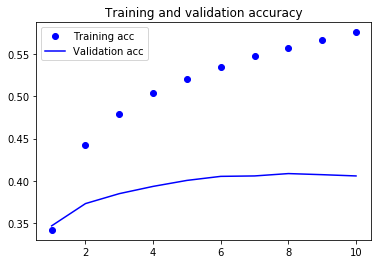

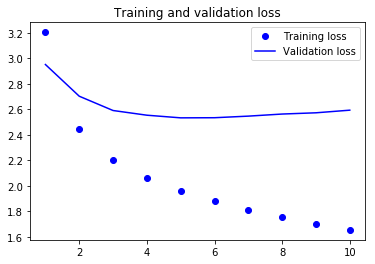

best validation accuracy:  0.4083999999523163


In [23]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(num_words,)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 10,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks = [early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

# Two layers of hidden units
A slight improvement over one layer of hidden units (<1%)

In [ ]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dense(128, activation='relu', 
                kernel_regularizer = regularizers.l2(0.0025)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## Two layer network with dropout and regularization

Takes longer to train than the network with neither. Some improvements in accuracy but it's a bit marginal.

In [ ]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu',
                kernel_regularizer = regularizers.l2(0.002)))
model.add(Dropout(0.4))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)

In [ ]:
print ("best validation accuracy: ", max(history.history['val_acc']))

# Embedding Layer

First of all, let's try just an embedding layer, into a classifier

In [15]:
x_train[0]

'RT @mydear_bangtan: [VID] 181023 - Foi adicionada a letra “D” no outdoor misterioso do #BTS em Hollywood.\nFormando: BTS AND... \n\n ILOVEPAR…'

In [16]:
# Tokenize the tweets into lists of words

maxlen = 25

def convert_to_sequences(tweet_text, tokenizer, maxlen=20):
    tweet_sequence = np.asarray(tokenizer.texts_to_sequences(tweet_text))
    padded = pad_sequences (tweet_sequence, maxlen=maxlen)
    return (padded)

x_train_sequences = convert_to_sequences(x_train, tokenizer, maxlen=maxlen)
x_dev_sequences = convert_to_sequences(x_dev, tokenizer, maxlen=maxlen)
x_test_sequences = convert_to_sequences(x_test, tokenizer, maxlen=maxlen)

In [17]:
n_output_classes = y_dev_idx.shape[1]

def simple_embedding_model(num_words, n_output_classes, n_embedding_dims = 16, max_sequence_length = 20):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 

    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

In [ ]:
clear_session()

model = simple_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 64, 
                               max_sequence_length = maxlen)    

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=1, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding.h5',
                                             monitor='val_acc',
                                             save_best_only = True)

tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
                                          #write_grads=1,
                                          #histogram_freq=1,
                                          embeddings_freq=1,
                                          embeddings_data='embedding') ## ?? How to implement this

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 20,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)

In [ ]:
print ("best validation accuracy: ", max(history.history['val_acc']))

In [ ]:
def deeper_embedding_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           dense2_size = 16,
                           dropout2_rate = 0.2,
                           lambd = 0.0):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 
    
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    model.add(Dense(dense2_size, activation='relu',
                    kernel_regularizer = regularizers.l2(lambd)))
    model.add(Dropout(dropout2_rate))
    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

In [ ]:
clear_session()

model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 28, 
                               max_sequence_length = maxlen,
                               lambd = 0.0006)    

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

Conclusions:
The embedding->shallow NN model struggles to get above 31% accuracy. Actually best results obtained when number of embedding dimensions is small: ~3-4. 

## Tuning parameters for a much bigger (100,000) tweet training dataset

In [12]:
clear_session()

model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 128,          #196      # 128
                               max_sequence_length = maxlen,
                               dense1_size = 128,               # 160     # 128
                               dropout1_rate = 0.4,           # 0.35
                               dense2_size = 96,             # 128   # 96
                               dropout2_rate = 0.4,           # 0.35
                               lambd = 0.0025)                # 0.0015

                           
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

NameError: name 'deeper_embedding_model' is not defined

# Simple LSTM model

In [18]:
def simple_lstm_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           lambd = 0.0):

    model = Sequential()

    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 
    model.add(LSTM(n_embedding_dims))
    # model.add(Flatten()) 
    
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

In [21]:
clear_session()

model = simple_lstm_model(num_words,
                          n_output_classes, 
                          n_embedding_dims = 90,          
                          max_sequence_length = maxlen,
                          dense1_size = 128,               
                          dropout1_rate = 0.2,           
                          lambd = 0.0025)                

tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log')
                                          #write_grads=1,
                                          #histogram_freq=1,
                                          #embeddings_freq=1,
                                          #embeddings_data='embedding') ## ?? How to implement this


early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early, tensorboard])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 165s 2ms/step - loss: 3.5218 - acc: 0.2257 - val_loss: 3.3117 - val_acc: 0.2564
Epoch 2/50
100000/100000 [==============================] - 147s 1ms/step - loss: 2.9270 - acc: 0.3226 - val_loss: 2.9655 - val_acc: 0.3157
Epoch 3/50
100000/100000 [==============================] - 159s 2ms/step - loss: 2.6227 - acc: 0.3853 - val_loss: 2.9134 - val_acc: 0.3280
Epoch 4/50
100000/100000 [==============================] - 152s 2ms/step - loss: 2.4562 - acc: 0.4210 - val_loss: 2.7880 - val_acc: 0.3452
Epoch 5/50
100000/100000 [==============================] - 168s 2ms/step - loss: 2.3499 - acc: 0.4450 - val_loss: 2.7140 - val_acc: 0.3683
Epoch 6/50
100000/100000 [==============================] - 166s 2ms/step - loss: 2.2755 - acc: 0.4602 - val_loss: 2.7755 - val_acc: 0.3613
Epoch 7/50
100000/100000 [==============================] - 157s 2ms/step - loss: 2.2170 - acc: 0.4722 - val_

NameError: name 'plot_train_history' is not defined